# Ensemble (XGBoost + CatBoost + LightGBM) prediction for road accident 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/train.csv')
test_df = pd.read_csv('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/test.csv')

print(train_df.info())
print("\nMissing values in train:", train_df.isnull().sum().sum())
print("Missing values in test:", test_df.isnull().sum().sum())

# basic statistics
print(train_df['accident_risk'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [4]:
def create_advanced_features(df):
    df_copy = df.copy()
    
    # Basic interactions from your original features
    df_copy['speed_curvature'] = df_copy['speed_limit'] * df_copy['curvature']
    df_copy['lanes_speed'] = df_copy['num_lanes'] * df_copy['speed_limit']
    
    # Risk encodings
    weather_risk = {'clear': 0, 'rainy': 1, 'foggy': 2}
    lighting_risk = {'daylight': 0, 'dim': 1, 'night': 2}
    time_risk = {'morning': 0, 'afternoon': 1, 'evening': 2, 'night': 3}
    
    df_copy['weather_risk'] = df_copy['weather'].map(weather_risk)
    df_copy['lighting_risk'] = df_copy['lighting'].map(lighting_risk)
    df_copy['time_risk'] = df_copy['time_of_day'].map(time_risk)
    
    # Combined risk score
    df_copy['environment_risk'] = df_copy['weather_risk'] + df_copy['lighting_risk'] + df_copy['time_risk']
    
    # Advanced features
    df_copy['complexity_score'] = (df_copy['curvature'] * df_copy['speed_limit'] * 
                                 df_copy['num_lanes']) / 100
    
    # Visibility risk (combination of lighting + weather)
    lighting_scores = {'daylight': 0, 'dim': 2, 'night': 3}
    weather_scores = {'clear': 0, 'rainy': 2, 'foggy': 3}
    df_copy['visibility_risk'] = (df_copy['lighting'].map(lighting_scores) + 
                                df_copy['weather'].map(weather_scores))
    
    # Time risk amplification
    time_scores = {'morning': 1, 'afternoon': 1.2, 'evening': 1.5, 'night': 2}
    df_copy['time_amplifier'] = df_copy['time_of_day'].map(time_scores)
    
    # Road type encoding
    road_scores = {'urban': 1, 'rural': 1.5, 'highway': 2}
    df_copy['road_type_encoded'] = df_copy['road_type'].map(road_scores)
    
    # Combined risk score
    df_copy['composite_risk'] = (
        df_copy['complexity_score'] * 
        df_copy['visibility_risk'] * 
        df_copy['time_amplifier'] * 
        df_copy['road_type_encoded']
    ) / 10
    
    # Peak hour flag
    df_copy['peak_hour'] = ((df_copy['time_of_day'].isin(['morning', 'evening'])) & 
                           (df_copy['holiday'] == 'False')).astype(int)
    
    # Dangerous combinations
    df_copy['high_risk_combo'] = (
        (df_copy['weather'].isin(['foggy', 'rainy'])) &
        (df_copy['lighting'].isin(['dim', 'night'])) &
        (df_copy['curvature'] > 0.5)
    ).astype(int)
    
    return df_copy

train_df = create_advanced_features(train_df)
test_df = create_advanced_features(test_df)
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (517754, 27), Test shape: (172585, 26)


In [5]:
# Updated features list with advanced features
features_to_use = [
    'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 
    'weather', 'road_signs_present', 'public_road', 'time_of_day', 
    'holiday', 'school_season', 'num_reported_accidents',
    'speed_curvature', 'lanes_speed', 'weather_risk', 
    'lighting_risk', 'time_risk', 'environment_risk',
    'complexity_score', 'visibility_risk', 'time_amplifier',
    'road_type_encoded', 'composite_risk', 'peak_hour', 'high_risk_combo'
]

X = train_df[features_to_use]
y = train_df['accident_risk']
X_test = test_df[features_to_use]

# Identifying categorical features for CatBoost
categorical_features = [
    'road_type', 'lighting', 'weather', 'road_signs_present', 
    'public_road', 'time_of_day', 'holiday', 'school_season'
]

# Converting boolean columns to strings for proper handling
for col in ['road_signs_present', 'public_road', 'holiday', 'school_season']:
    X[col] = X[col].astype(str)
    X_test[col] = X_test[col].astype(str)

print(f"Total features: {len(features_to_use)}")
print(f"Categorical features: {categorical_features}")

Total features: 25
Categorical features: ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']


In [6]:
def prepare_xgboost_features_simple(X, X_test=None):
    """Simpler version - converting everything to numeric"""
    X_xgb = X.copy()
    
    if X_test is not None:
        X_test_xgb = X_test.copy()
    else:
        X_test_xgb = None
    
    # Converting all categorical columns using label encoding
    categorical_cols = ['road_type', 'lighting', 'weather', 'time_of_day', 
                       'road_signs_present', 'public_road', 'holiday', 'school_season']
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_xgb[col] = le.fit_transform(X_xgb[col].astype(str))
        if X_test is not None:
            # Handling unseen labels in test set
            unique_train = set(le.classes_)
            X_test_xgb[col] = X_test_xgb[col].astype(str).apply(
                lambda x: le.transform([x])[0] if x in unique_train else -1
            )
    
    if X_test is not None:
        return X_xgb, X_test_xgb
    return X_xgb

In [7]:
from lightgbm import LGBMRegressor

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

# Preparing data for all models
X_train_cat = X_train.copy()
X_val_cat = X_val.copy()
X_test_cat = X_test.copy()

# Preparing XGBoost features (label encoded)
X_train_xgb, X_val_xgb = prepare_xgboost_features_simple(X_train, X_val)
X_test_xgb = prepare_xgboost_features_simple(X_test)

# For LightGBM model
X_train_lgb, X_val_lgb = prepare_xgboost_features_simple(X_train, X_val)
X_test_lgb = prepare_xgboost_features_simple(X_test)

# CatBoost model
cat_model = CatBoostRegressor(
    cat_features=categorical_features,
    random_state=42,
    verbose=False,
    iterations=800,  
    learning_rate=0.03,  
    depth=8,  
    l2_leaf_reg=3,  
    random_strength=0.5, 
    bagging_temperature=0.8,  
    early_stopping_rounds=50
)

# XGBoost model
xgb_model = XGBRegressor(
    random_state=42,
    n_estimators=800,  
    learning_rate=0.03,
    max_depth=8, 
    subsample=0.85,  
    colsample_bytree=0.8,
    colsample_bylevel=0.8,  
    reg_alpha=0.2,  
    reg_lambda=0.3,  
    gamma=0.1,  
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbosity=0  
)

# LightGBM model
lgb_model = LGBMRegressor(
    random_state=42,
    n_estimators=800,  
    learning_rate=0.03,  
    max_depth=8,  
    num_leaves=45,  
    subsample=0.85,  
    colsample_bytree=0.8,
    reg_alpha=0.2,  
    reg_lambda=0.3,  
    min_child_samples=25,  
    min_child_weight=0.001, 
    verbose=-1
)


# Model training
print("Training models...")

print("Training CatBoost...", end=" ")
cat_model.fit(X_train_cat, y_train, eval_set=[(X_val_cat, y_val)], verbose=False)
print("✓")

print("Training XGBoost...", end=" ")
xgb_model.fit(X_train_xgb, y_train, eval_set=[(X_val_xgb, y_val)], verbose=False)
print("✓")

print("Training LightGBM...", end=" ")
lgb_model.fit(X_train_lgb, y_train)
print("✓")

print("\nAll models trained successfully!")

# Predictions
cat_val_pred = cat_model.predict(X_val_cat)
xgb_val_pred = xgb_model.predict(X_val_xgb)
lgb_val_pred = lgb_model.predict(X_val_lgb)

cat_test_pred = cat_model.predict(X_test_cat)
xgb_test_pred = xgb_model.predict(X_test_xgb)
lgb_test_pred = lgb_model.predict(X_test_lgb)

print("Predictions ready for ensemble!")

Training samples: 414203
Validation samples: 103551
Training models...
Training CatBoost... ✓
Training XGBoost... ✓
Training LightGBM... ✓

All models trained successfully!
Predictions ready for ensemble!


In [8]:
from sklearn.linear_model import Ridge

print("Creating stacking ensemble...")

# Getting predictions from all models
cat_train_pred = cat_model.predict(X_train_cat)
cat_val_pred = cat_model.predict(X_val_cat)
cat_test_pred = cat_model.predict(X_test_cat)

xgb_train_pred = xgb_model.predict(X_train_xgb)
xgb_val_pred = xgb_model.predict(X_val_xgb)
xgb_test_pred = xgb_model.predict(X_test_xgb)

lgb_train_pred = lgb_model.predict(X_train_lgb)
lgb_val_pred = lgb_model.predict(X_val_lgb)
lgb_test_pred = lgb_model.predict(X_test_lgb)

# Create stacking features (use all 3 models)
level1_train = np.column_stack([cat_train_pred, xgb_train_pred, lgb_train_pred])
level1_val = np.column_stack([cat_val_pred, xgb_val_pred, lgb_val_pred])
level1_test = np.column_stack([cat_test_pred, xgb_test_pred, lgb_test_pred])

print(f"Stacking feature shapes:")
print(f"Train: {level1_train.shape}")
print(f"Val: {level1_val.shape}") 
print(f"Test: {level1_test.shape}")

# Train meta-model
meta_model = Ridge(alpha=0.1)
meta_model.fit(level1_train, y_train)

# Make stacking predictions
stacking_val_pred = meta_model.predict(level1_val)
stacking_test_pred = meta_model.predict(level1_test)

print("Stacking ensemble training completed!")

Creating stacking ensemble...
Stacking feature shapes:
Train: (414203, 3)
Val: (103551, 3)
Test: (172585, 3)
Stacking ensemble training completed!


In [9]:
# Calculate individual model performances with multiple metrics
cat_val_rmse = np.sqrt(mean_squared_error(y_val, cat_val_pred))
xgb_val_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_pred))
lgb_val_rmse = np.sqrt(mean_squared_error(y_val, lgb_val_pred))
stack_val_rmse = np.sqrt(mean_squared_error(y_val, stacking_val_pred))

cat_mae = mean_absolute_error(y_val, cat_val_pred)
xgb_mae = mean_absolute_error(y_val, xgb_val_pred)
lgb_mae = mean_absolute_error(y_val, lgb_val_pred)

# Combined score (RMSE + MAE)
def combined_score(rmse, mae):
    return 0.7 * rmse + 0.3 * mae  # Weight RMSE more heavily

cat_score = combined_score(cat_val_rmse, cat_mae)
xgb_score = combined_score(xgb_val_rmse, xgb_mae)
lgb_score = combined_score(lgb_val_rmse, lgb_mae)
stack_score = combined_score(stack_val_rmse, 0)

# Performance-based weights with exponential decay (better models get much higher weight)
models_scores = {
    'CatBoost': cat_score,
    'XGBoost': xgb_score,
    'LightGBM': lgb_score,
    'Stacking': stack_score
}

# Exponential weighting (emphasizes differences between models)
weights = {}
total_weight = 0
for name, score in models_scores.items():
    weights[name] = np.exp(-score * 5) 
    total_weight += weights[name]

# Normalize weights
for name in weights:
    weights[name] /= total_weight

print("\nSmart Model Weights:")
for name, weight in weights.items():
    print(f"{name}: {weight:.3f}")

# Super ensemble with smart weighting
super_ensemble_val = (
    weights['CatBoost'] * cat_val_pred +
    weights['XGBoost'] * xgb_val_pred +
    weights['LightGBM'] * lgb_val_pred +
    weights['Stacking'] * stacking_val_pred
)

super_ensemble_test = (
    weights['CatBoost'] * cat_test_pred +
    weights['XGBoost'] * xgb_test_pred +
    weights['LightGBM'] * lgb_test_pred +
    weights['Stacking'] * stacking_test_pred
)


Smart Model Weights:
CatBoost: 0.246
XGBoost: 0.246
LightGBM: 0.246
Stacking: 0.262


In [10]:
super_ensemble_val_rmse = np.sqrt(mean_squared_error(y_val, super_ensemble_val))
super_ensemble_val_mae = mean_absolute_error(y_val, super_ensemble_val)

print(f"\n=== SUPER ENSEMBLE PERFORMANCE ===")
print(f"Super Ensemble RMSE: {super_ensemble_val_rmse:.4f}")
print(f"Super Ensemble MAE: {super_ensemble_val_mae:.4f}")

# Individual model performance for comparison
print(f"\nCatBoost RMSE: {cat_val_rmse:.4f}")
print(f"XGBoost RMSE: {xgb_val_rmse:.4f}")
print(f"LightGBM RMSE: {lgb_val_rmse:.4f}")
print(f"Stacking RMSE: {stack_val_rmse:.4f}")

# Calculating improvement
improvement = ((min(cat_val_rmse, xgb_val_rmse) - super_ensemble_val_rmse) / 
               min(cat_val_rmse, xgb_val_rmse) * 100)
print(f"Improvement over best single model: {improvement:.4f}%")


=== SUPER ENSEMBLE PERFORMANCE ===
Super Ensemble RMSE: 0.0563
Super Ensemble MAE: 0.0437

CatBoost RMSE: 0.0563
XGBoost RMSE: 0.0564
LightGBM RMSE: 0.0563
Stacking RMSE: 0.0565
Improvement over best single model: 0.0962%


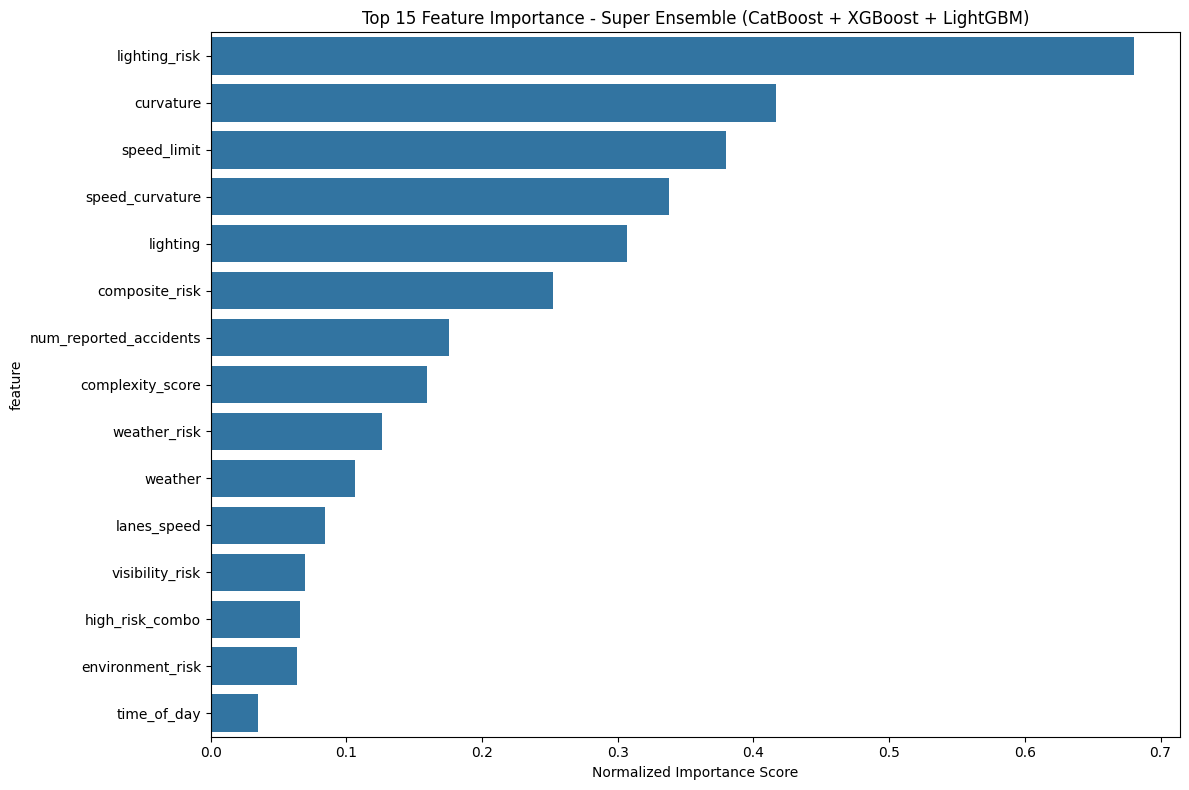

                      Super Ensemble Feature Importance               
                   feature  importance_avg  importance_cat  importance_xgb  \
15           lighting_risk        0.680332        1.000000        1.000000   
2                curvature        0.416669        0.214884        0.035124   
3              speed_limit        0.379487        0.719074        0.142254   
12         speed_curvature        0.338020        0.038576        0.293462   
4                 lighting        0.306585        0.002043        0.734648   
22          composite_risk        0.252493        0.001398        0.115799   
11  num_reported_accidents        0.175227        0.101820        0.026574   
18        complexity_score        0.159039        0.001064        0.031507   
14            weather_risk        0.126106        0.261158        0.036509   
5                  weather        0.106391        0.002970        0.060836   

    importance  
15    0.040996  
2     1.000000  
3     0.277132  
12

In [11]:
# LightGBM importance
lgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
})
lgb_importance['importance'] = lgb_importance['importance'] / lgb_importance['importance'].max()

cat_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': cat_model.get_feature_importance()
})
cat_importance['importance'] = cat_importance['importance'] / cat_importance['importance'].max()

xgb_importance = pd.DataFrame({
    'feature': X.columns, 
    'importance': xgb_model.feature_importances_
})
xgb_importance['importance'] = xgb_importance['importance'] / xgb_importance['importance'].max()

# Combining all three models
combined_importance = pd.merge(
    pd.merge(cat_importance, xgb_importance, on='feature', suffixes=('_cat', '_xgb')),
    lgb_importance, on='feature'
)
combined_importance['importance_avg'] = (
    combined_importance['importance_cat'] + 
    combined_importance['importance_xgb'] + 
    combined_importance['importance']
) / 3
combined_importance = combined_importance.sort_values('importance_avg', ascending=False)

# Plotting combined importance
plt.figure(figsize=(12, 8))
sns.barplot(data=combined_importance.head(15), x='importance_avg', y='feature')
plt.title('Top 15 Feature Importance - Super Ensemble (CatBoost + XGBoost + LightGBM)')
plt.xlabel('Normalized Importance Score')
plt.tight_layout()
plt.show()

print("                      Super Ensemble Feature Importance               ")
print(combined_importance.head(10)[['feature', 'importance_avg', 'importance_cat', 'importance_xgb', 'importance']])

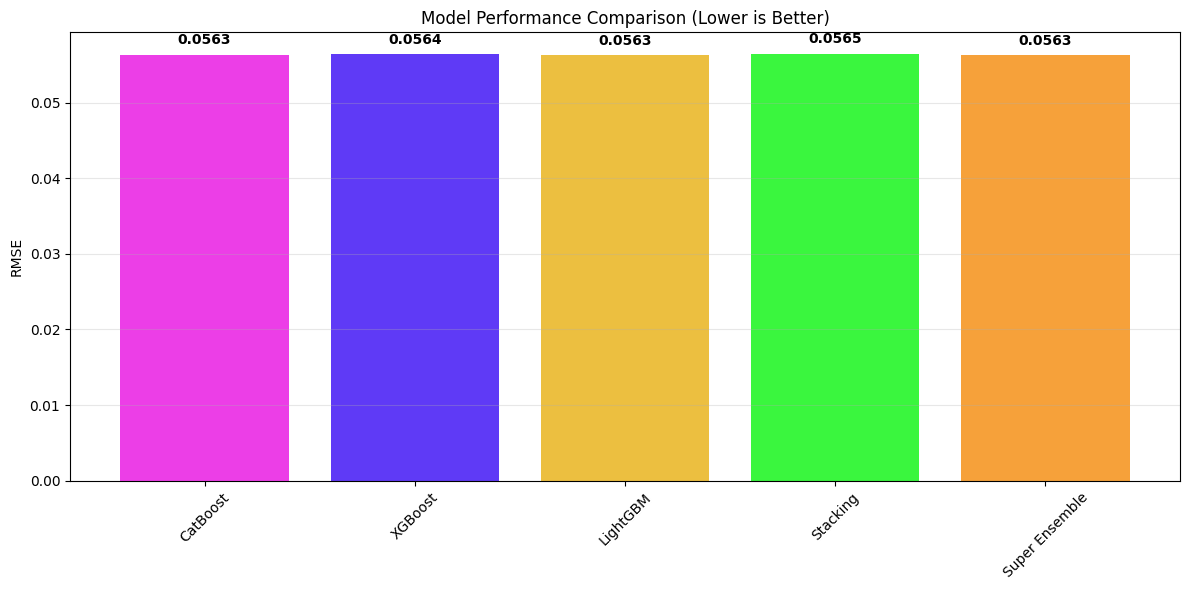

In [12]:
models_performance = {
    'CatBoost': cat_val_rmse,
    'XGBoost': xgb_val_rmse,
    'LightGBM': lgb_val_rmse,
    'Stacking': stack_val_rmse,
    'Super Ensemble': super_ensemble_val_rmse
}

plt.figure(figsize=(12, 6))
colors = ["#E80EE1", "#3708F4", "#E8AF10", "#09F40D", "#F48A08"]
plt.bar(models_performance.keys(), models_performance.values(), color=colors, alpha=0.8)
plt.ylabel('RMSE')
plt.title('Model Performance Comparison (Lower is Better)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# Adding value labels on bars
for i, (model, rmse) in enumerate(models_performance.items()):
    plt.text(i, rmse + 0.001, f'{rmse:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

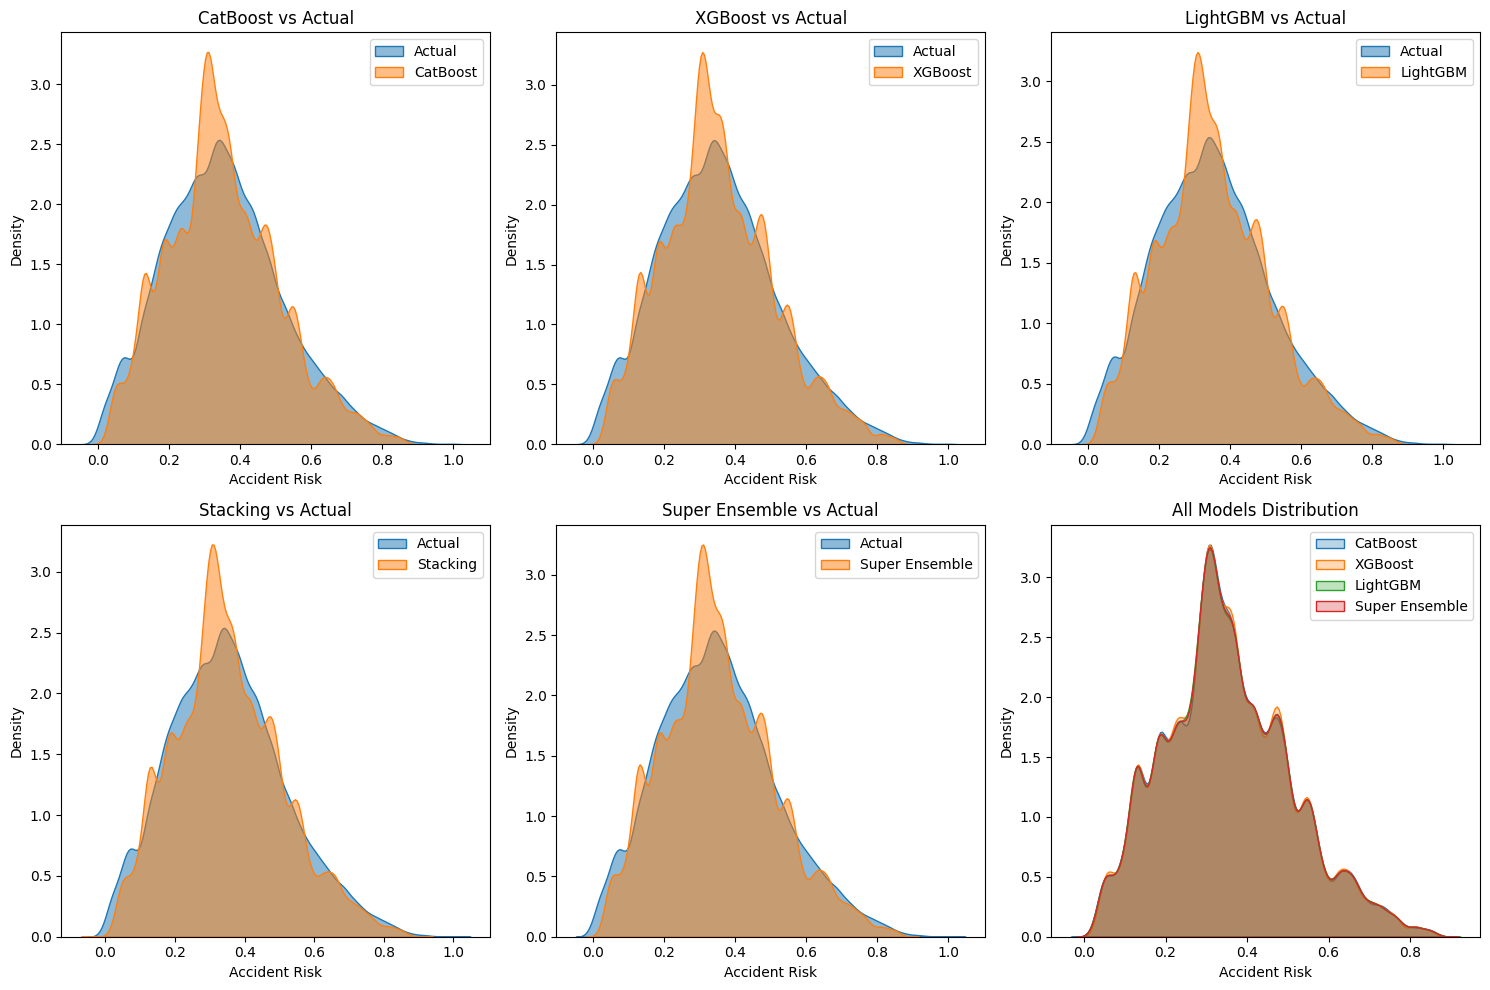

In [13]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.kdeplot(y_val, label='Actual', fill=True, alpha=0.5)
sns.kdeplot(cat_val_pred, label='CatBoost', fill=True, alpha=0.5)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('CatBoost vs Actual')
plt.legend()

plt.subplot(2, 3, 2)
sns.kdeplot(y_val, label='Actual', fill=True, alpha=0.5)
sns.kdeplot(xgb_val_pred, label='XGBoost', fill=True, alpha=0.5)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('XGBoost vs Actual')
plt.legend()

plt.subplot(2, 3, 3)
sns.kdeplot(y_val, label='Actual', fill=True, alpha=0.5)
sns.kdeplot(lgb_val_pred, label='LightGBM', fill=True, alpha=0.5)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('LightGBM vs Actual')
plt.legend()

plt.subplot(2, 3, 4)
sns.kdeplot(y_val, label='Actual', fill=True, alpha=0.5)
sns.kdeplot(stacking_val_pred, label='Stacking', fill=True, alpha=0.5)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('Stacking vs Actual')
plt.legend()

plt.subplot(2, 3, 5)
sns.kdeplot(y_val, label='Actual', fill=True, alpha=0.5)
sns.kdeplot(super_ensemble_val, label='Super Ensemble', fill=True, alpha=0.5)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('Super Ensemble vs Actual')
plt.legend()

plt.subplot(2, 3, 6)
sns.kdeplot(cat_val_pred, label='CatBoost', fill=True, alpha=0.3)
sns.kdeplot(xgb_val_pred, label='XGBoost', fill=True, alpha=0.3)
sns.kdeplot(lgb_val_pred, label='LightGBM', fill=True, alpha=0.3)
sns.kdeplot(super_ensemble_val, label='Super Ensemble', fill=True, alpha=0.3)
plt.xlabel('Accident Risk')
plt.ylabel('Density')
plt.title('All Models Distribution')
plt.legend()

plt.tight_layout()
plt.show()

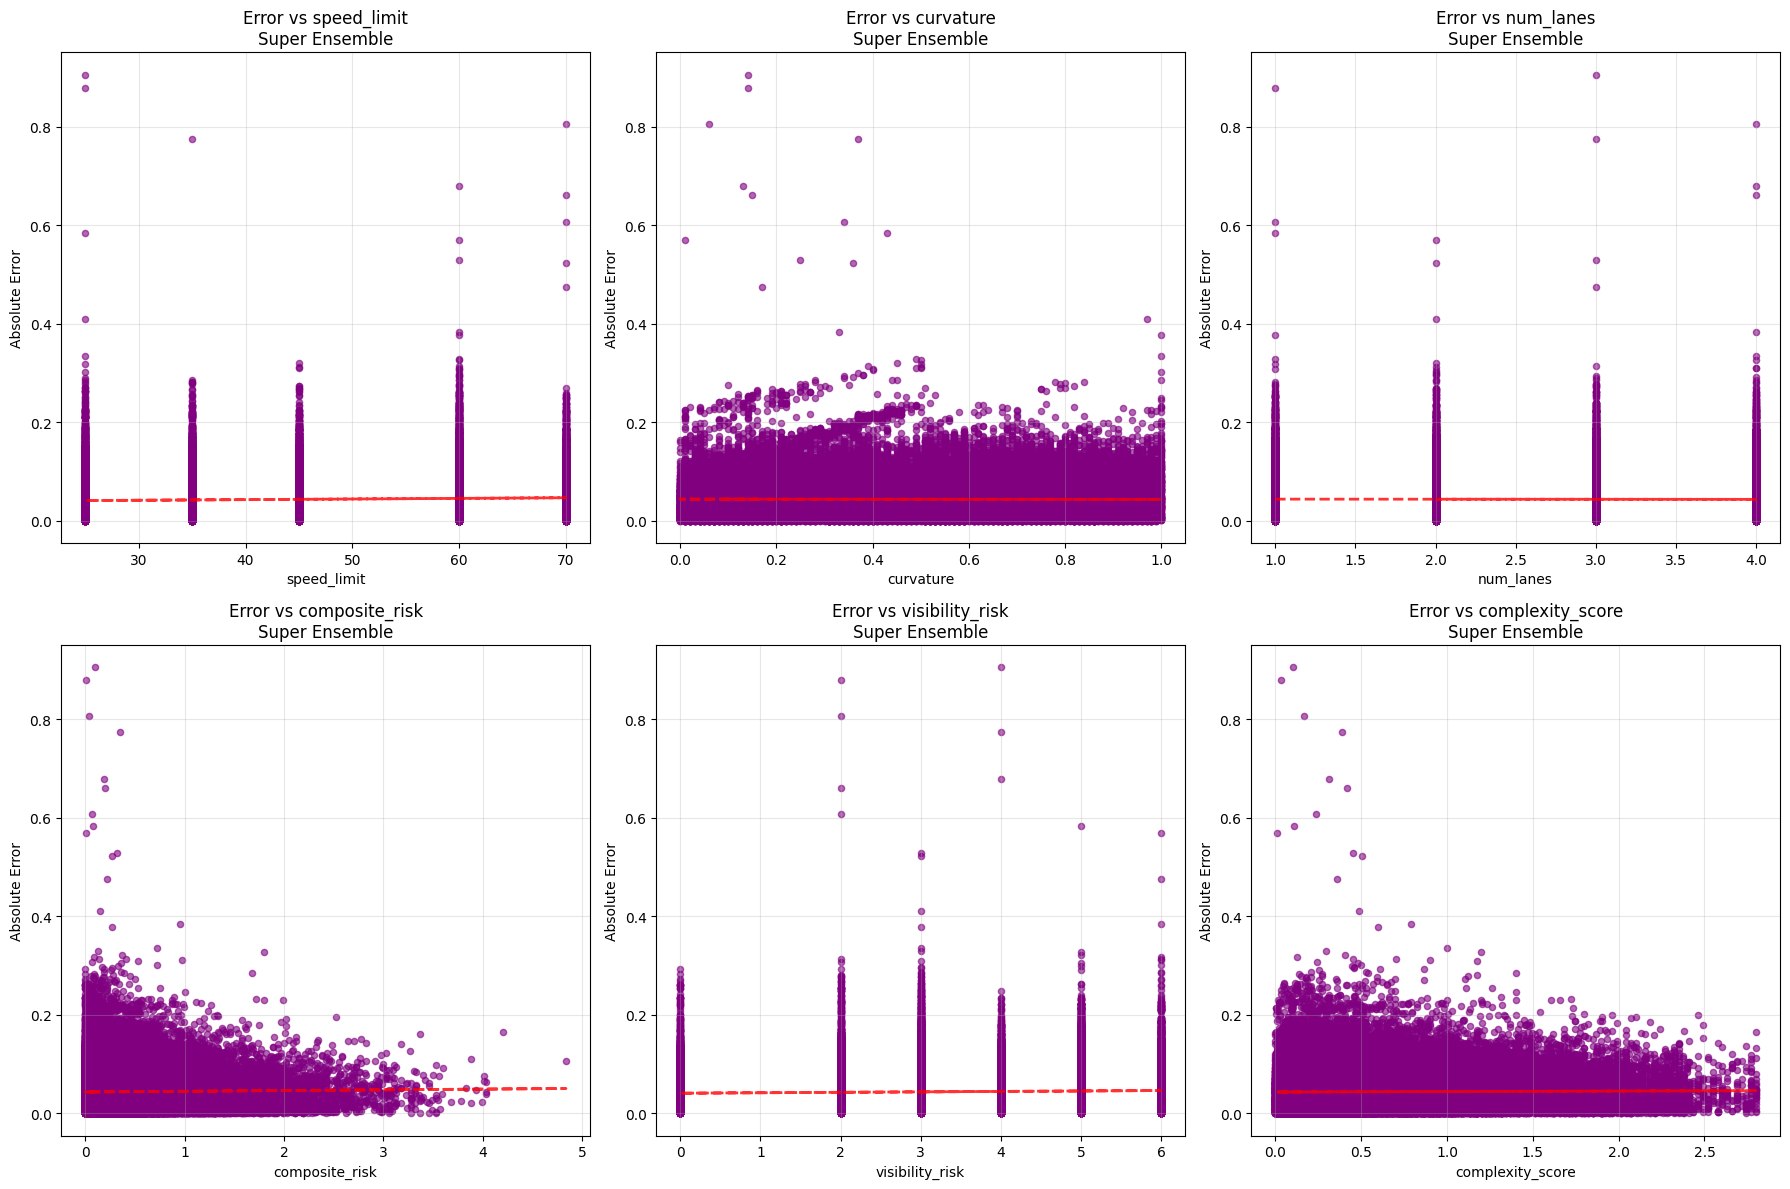

The red horizontal line in the plot is a trend line (linear regression line) that shows the relationship between feature values and prediction errors.



Error Analysis Summary:

speed_limit - Mean Absolute Error by range:
  (24.955, 36.25]: 0.0419
  (36.25, 47.5]: 0.0418
  (47.5, 58.75]: nan
  (58.75, 70.0]: 0.0468

curvature - Mean Absolute Error by range:
  (-0.001, 0.25]: 0.0435
  (0.25, 0.5]: 0.0444
  (0.5, 0.75]: 0.0438
  (0.75, 1.0]: 0.0429

num_lanes - Mean Absolute Error by range:
  (0.997, 1.75]: 0.0440
  (1.75, 2.5]: 0.0436
  (2.5, 3.25]: 0.0438
  (3.25, 4.0]: 0.0434


In [14]:
# Error analysis by important features
feature_analysis_df = pd.DataFrame({
    'actual': y_val,
    'predicted': super_ensemble_val,  
    'error': super_ensemble_val - y_val, 
    'abs_error': np.abs(super_ensemble_val - y_val) 
})

# Addding important features for analysis (using advanced features)
important_features = ['speed_limit', 'curvature', 'num_lanes', 'composite_risk', 'visibility_risk', 'complexity_score']
for feature in important_features:
    if feature in X_val.columns:
        feature_analysis_df[feature] = X_val[feature].values
    else:
        print(f"Warning: {feature} not found in features, using fallback")
        # Fallback to basic features if advanced ones are missing
        important_features = ['speed_limit', 'curvature', 'num_lanes', 'weather_risk', 'time_risk', 'environment_risk']
        break

# Plotting error vs important features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(important_features[:6]):
    if feature in feature_analysis_df.columns:
        axes[i].scatter(feature_analysis_df[feature], feature_analysis_df['abs_error'], 
                       alpha=0.6, s=20, color='purple')
        # Adding trend line
        z = np.polyfit(feature_analysis_df[feature], feature_analysis_df['abs_error'], 1)
        p = np.poly1d(z)
        axes[i].plot(feature_analysis_df[feature], p(feature_analysis_df[feature]), 
                    "r--", alpha=0.8, linewidth=2)
        
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Absolute Error')
        axes[i].set_title(f'Error vs {feature}\nSuper Ensemble')
        axes[i].grid(alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'{feature} not available', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Missing: {feature}')

# Removing empty subplots
for i in range(len(important_features), 6):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

print("The red horizontal line in the plot is a trend line (linear regression line) that shows the relationship between feature values and prediction errors.")
print("\n")
# Print error statistics by feature ranges
print("\nError Analysis Summary:")
for feature in important_features[:3]:  # Shows top 3 features
    if feature in feature_analysis_df.columns:
        feature_analysis_df[f'{feature}_bin'] = pd.cut(feature_analysis_df[feature], bins=4)
        error_by_bin = feature_analysis_df.groupby(f'{feature}_bin')['abs_error'].mean()
        print(f"\n{feature} - Mean Absolute Error by range:")
        for bin_range, error in error_by_bin.items():
            print(f"  {bin_range}: {error:.4f}")

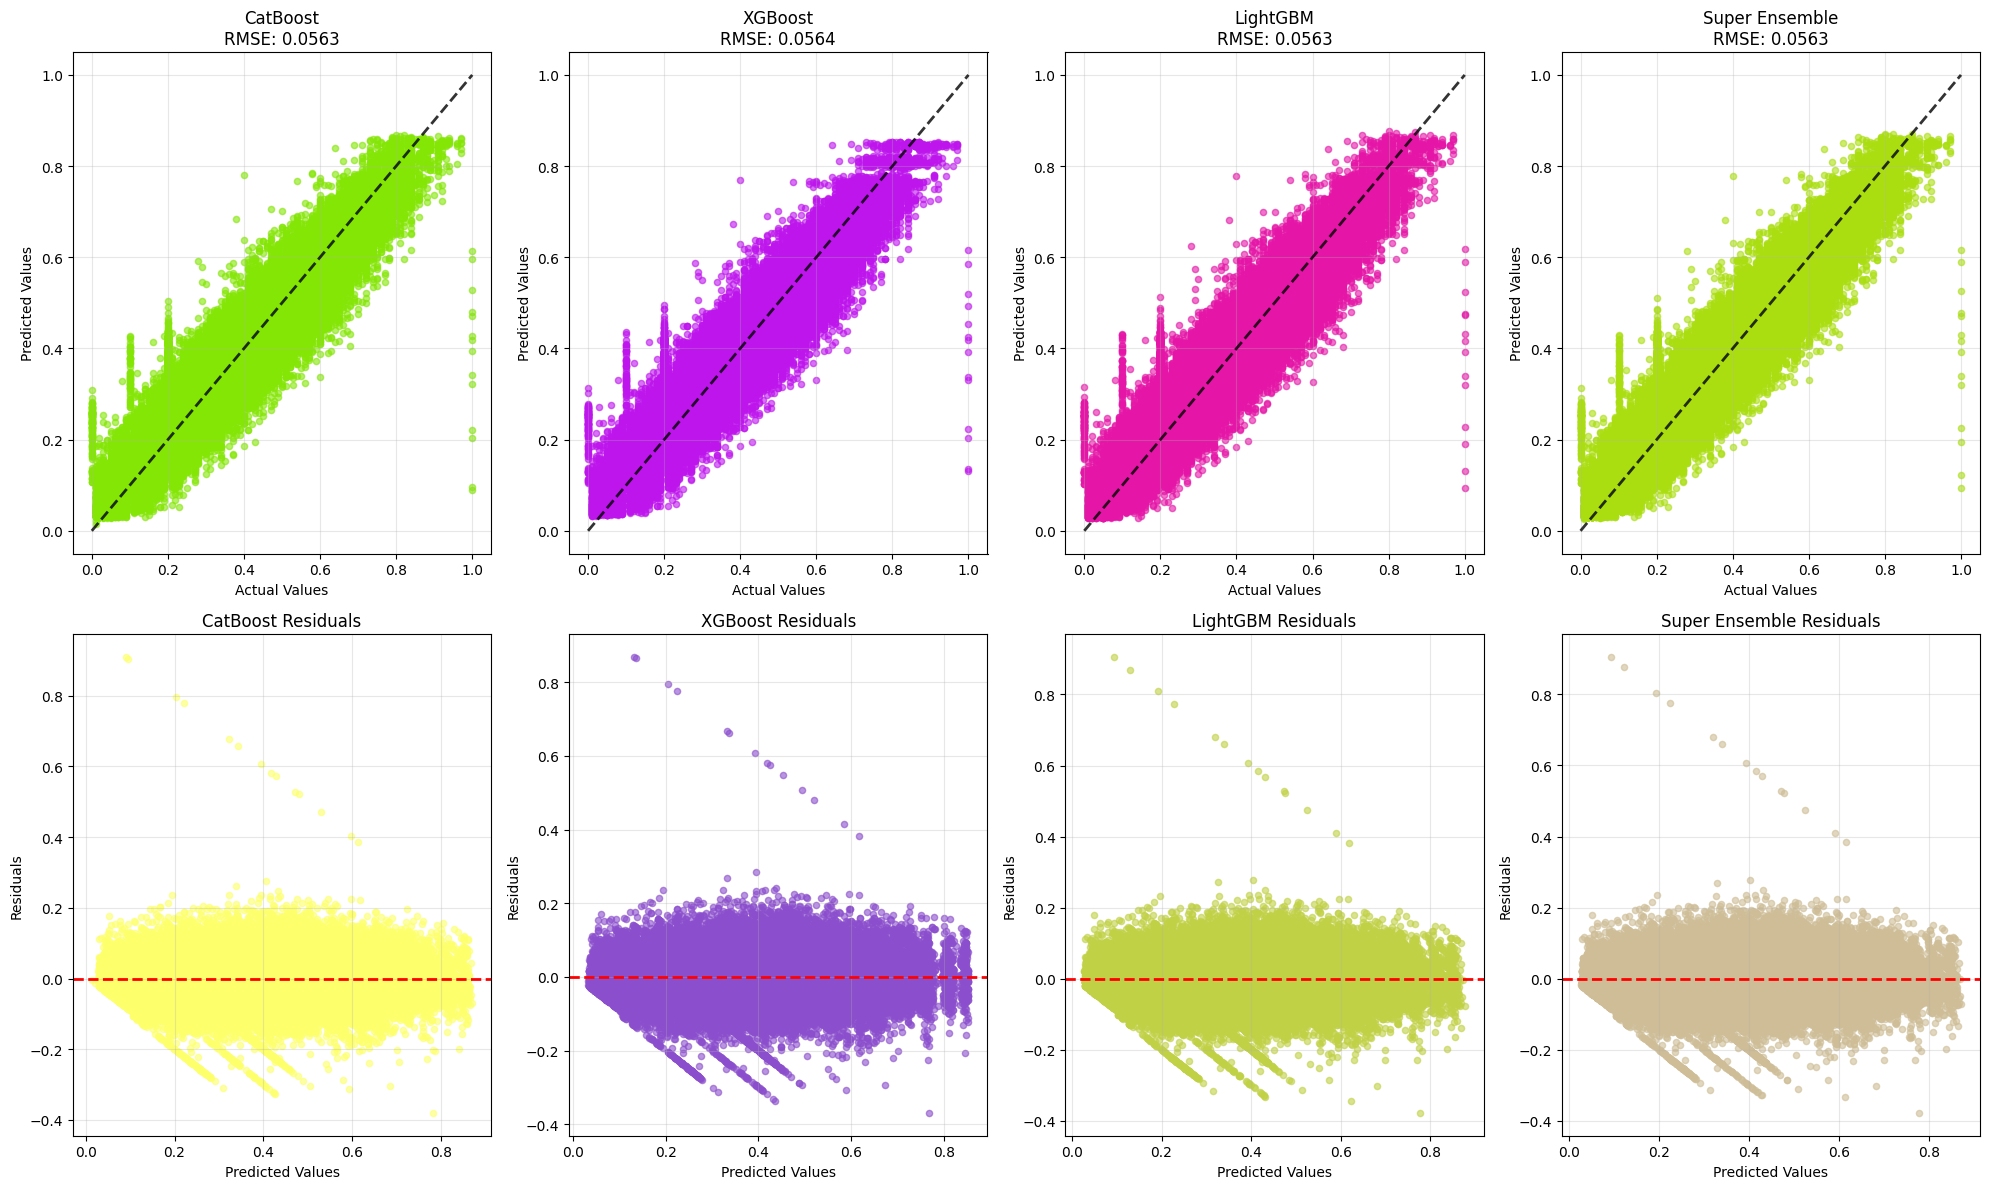

In [15]:
plt.figure(figsize=(20, 12))

# Row 1: Actual vs Predicted plots for all models
plt.subplot(2, 4, 1)
plt.scatter(y_val, cat_val_pred, alpha=0.6, label='CatBoost', s=20, color="#84E605")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'CatBoost\nRMSE: {cat_val_rmse:.4f}')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 2)
plt.scatter(y_val, xgb_val_pred, alpha=0.6, label='XGBoost', s=20, color="#BE15ED")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'XGBoost\nRMSE: {xgb_val_rmse:.4f}')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 3)
plt.scatter(y_val, lgb_val_pred, alpha=0.6, label='LightGBM', s=20, color="#E516A7")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'LightGBM\nRMSE: {lgb_val_rmse:.4f}')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 4)
plt.scatter(y_val, super_ensemble_val, alpha=0.6, label='Super Ensemble', s=20, color="#AADE10")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Super Ensemble\nRMSE: {super_ensemble_val_rmse:.4f}')
plt.grid(alpha=0.3)

# Row 2: Residual plots for all models
plt.subplot(2, 4, 5)
cat_residuals = y_val - cat_val_pred
plt.scatter(cat_val_pred, cat_residuals, alpha=0.6, s=20, color="#FDFF6B")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('CatBoost Residuals')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 6)
xgb_residuals = y_val - xgb_val_pred
plt.scatter(xgb_val_pred, xgb_residuals, alpha=0.6, s=20, color="#8B4ECD")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('XGBoost Residuals')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 7)
lgb_residuals = y_val - lgb_val_pred
plt.scatter(lgb_val_pred, lgb_residuals, alpha=0.6, s=20, color="#C1D145")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('LightGBM Residuals')
plt.grid(alpha=0.3)

plt.subplot(2, 4, 8)
super_ensemble_residuals = y_val - super_ensemble_val
plt.scatter(super_ensemble_val, super_ensemble_residuals, alpha=0.6, s=20, color="#CEBD96")
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Super Ensemble Residuals')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

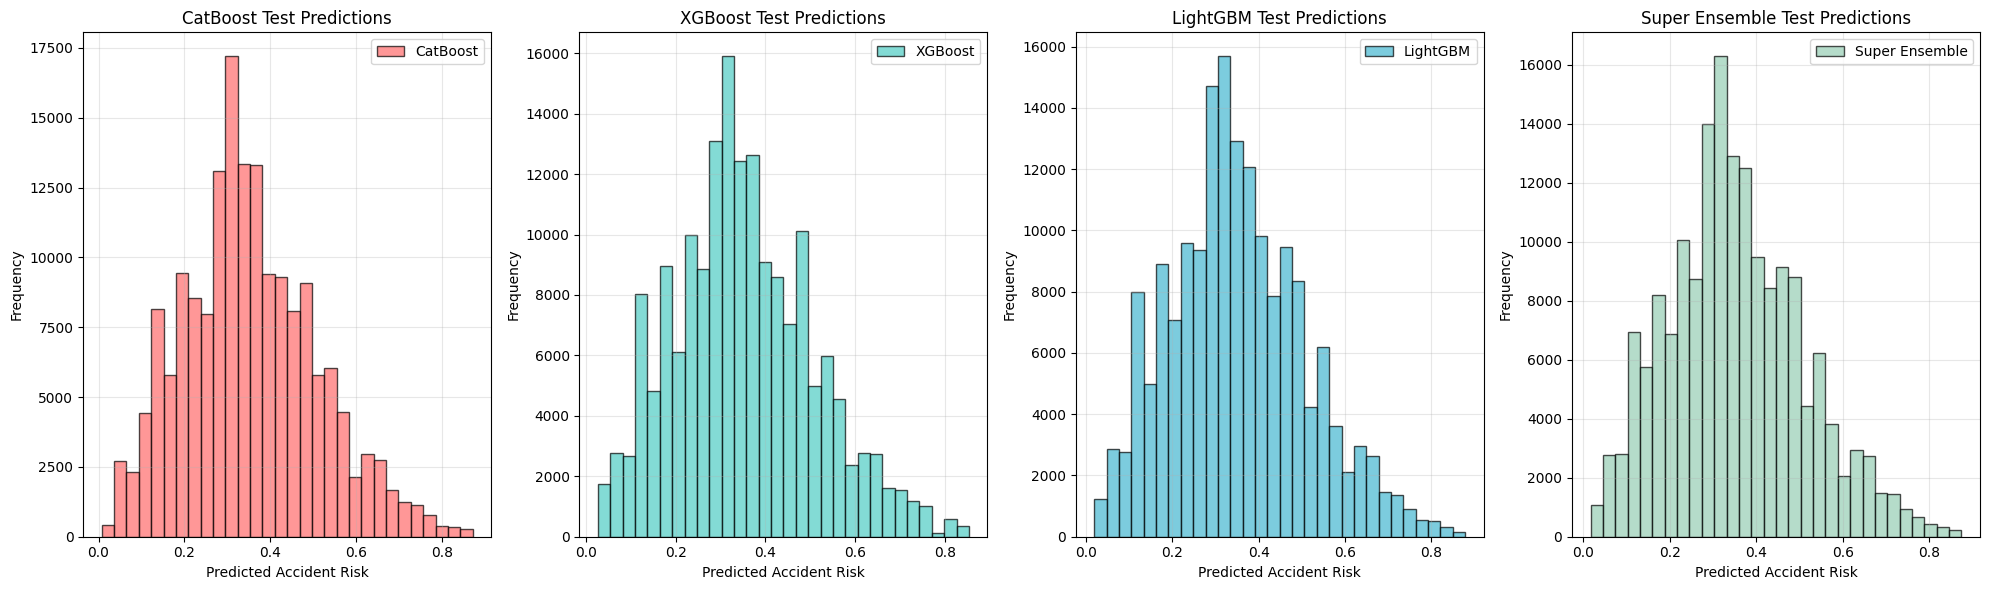

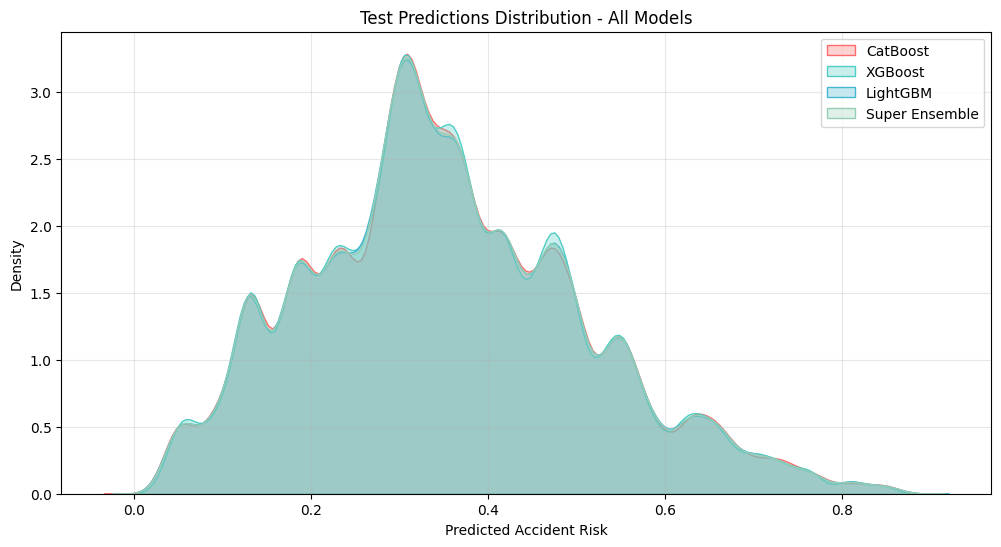

In [16]:
plt.figure(figsize=(20, 6))

# Test predictions distribution
plt.subplot(1, 4, 1)
plt.hist(cat_test_pred, bins=30, alpha=0.7, edgecolor='black', color='#FF6B6B', label='CatBoost')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Frequency')
plt.title('CatBoost Test Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 4, 2)
plt.hist(xgb_test_pred, bins=30, alpha=0.7, edgecolor='black', color='#4ECDC4', label='XGBoost')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Frequency')
plt.title('XGBoost Test Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 4, 3)
plt.hist(lgb_test_pred, bins=30, alpha=0.7, edgecolor='black', color='#45B7D1', label='LightGBM')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Frequency')
plt.title('LightGBM Test Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 4, 4)
plt.hist(super_ensemble_test, bins=30, alpha=0.7, edgecolor='black', color='#96CEB4', label='Super Ensemble')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Frequency')
plt.title('Super Ensemble Test Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Combined density plot
plt.figure(figsize=(12, 6))
sns.kdeplot(cat_test_pred, label='CatBoost', fill=True, alpha=0.3, color='#FF6B6B')
sns.kdeplot(xgb_test_pred, label='XGBoost', fill=True, alpha=0.3, color='#4ECDC4')
sns.kdeplot(lgb_test_pred, label='LightGBM', fill=True, alpha=0.3, color='#45B7D1')
sns.kdeplot(super_ensemble_test, label='Super Ensemble', fill=True, alpha=0.3, color='#96CEB4')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Density')
plt.title('Test Predictions Distribution - All Models')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [17]:
submission_df = pd.DataFrame({
    'id': test_df['id'].values,
    'accident_risk': super_ensemble_test
})

submission_df['accident_risk'] = submission_df['accident_risk'].clip(0, 1)
submission_df.to_csv('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/submission.csv', index=False)

print(f"\nSuper Ensemble predictions saved!")
print(f"Prediction range: [{submission_df['accident_risk'].min():.3f}, {submission_df['accident_risk'].max():.3f}]")
print(f"Mean prediction: {submission_df['accident_risk'].mean():.3f}")


Super Ensemble predictions saved!
Prediction range: [0.017, 0.874]
Mean prediction: 0.352


# XGB Boosting Over Residuals

# 🚀 Modern ML Improvements for Road Accident Prediction

## Advanced Techniques Implementation:
1. **Neural Networks & Deep Learning**
   - TabNet (attention-based deep learning for tabular data)
   - Multi-layer Perceptron with dropout and batch normalization
   
2. **Advanced Ensemble Methods**
   - Optuna hyperparameter optimization
   - Voting Regressor with optimized weights
   - Blending with cross-validation
   
3. **Modern Preprocessing**
   - Target encoding for categorical features
   - Feature selection using mutual information
   - Polynomial feature generation
   
4. **State-of-the-art Models**
   - NGBoost (Natural Gradient Boosting)
   - HistGradientBoostingRegressor (scikit-learn's modern gradient boosting)
   - Extra Trees with feature importance-based selection

In [18]:
# Install required modern ML libraries
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed successfully")

# Install modern ML libraries
packages_to_install = [
    'optuna',
    'pytorch-tabnet',
    'tensorflow', 
    'ngboost',
    'category_encoders'
]

for package in packages_to_install:
    install_package(package)

✓ optuna already installed
Installing pytorch-tabnet...
✓ pytorch-tabnet installed successfully
✓ tensorflow already installed
✓ ngboost already installed
✓ category_encoders already installed


In [19]:
# Import modern ML libraries and additional tools
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from category_encoders import TargetEncoder
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import MLE
import warnings
warnings.filterwarnings('ignore')

print("🚀 Modern ML libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Optuna version: {optuna.__version__}")

🚀 Modern ML libraries imported successfully!
TensorFlow version: 2.20.0
Optuna version: 4.5.0


In [20]:
# Advanced Feature Engineering Pipeline
def create_modern_features(df, target_col=None, is_train=True, target_encoder=None):
    """
    Modern feature engineering with target encoding, polynomial features, and feature interactions
    """
    df_copy = df.copy()
    
    # Apply previous advanced features
    df_copy = create_advanced_features(df_copy)
    
    # Target encoding for categorical features (only for training)
    categorical_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
    
    if is_train and target_col is not None:
        # Create and fit target encoder
        target_encoder = TargetEncoder(cols=categorical_cols)
        df_encoded = target_encoder.fit_transform(df_copy[categorical_cols], target_col)
        
        # Replace original categorical columns with target encoded versions
        for i, col in enumerate(categorical_cols):
            df_copy[f'{col}_target_encoded'] = df_encoded.iloc[:, i]
            
        # Store encoder for test set
        df_copy._target_encoder = target_encoder
    elif target_encoder is not None:
        # Apply pre-fitted encoder to test set
        df_encoded = target_encoder.transform(df_copy[categorical_cols])
        for i, col in enumerate(categorical_cols):
            df_copy[f'{col}_target_encoded'] = df_encoded.iloc[:, i]
    
    # Polynomial features for numerical columns (degree 2)
    numerical_cols = ['speed_limit', 'curvature', 'num_lanes', 'num_reported_accidents']
    poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_array = poly_features.fit_transform(df_copy[numerical_cols])
    
    # Add polynomial features with proper names
    poly_feature_names = poly_features.get_feature_names_out(numerical_cols)
    for i, name in enumerate(poly_feature_names):
        if name not in numerical_cols:  # Skip original features
            df_copy[f'poly_{name}'] = poly_array[:, i]
    
    # Advanced interaction features
    df_copy['risk_density'] = df_copy['num_reported_accidents'] / (df_copy['num_lanes'] + 1)
    df_copy['speed_per_lane'] = df_copy['speed_limit'] / (df_copy['num_lanes'] + 1)
    df_copy['curvature_speed_risk'] = df_copy['curvature'] * df_copy['speed_limit'] * df_copy['visibility_risk']
    
    # Time-based risk amplification
    df_copy['weekend_risk'] = (df_copy['holiday'] == 'True').astype(int) * df_copy['time_risk']
    df_copy['school_traffic_risk'] = (df_copy['school_season'] == 'True').astype(int) * df_copy['peak_hour']
    
    # Complex interaction terms
    df_copy['total_risk_score'] = (
        df_copy['composite_risk'] * 
        df_copy['environment_risk'] * 
        df_copy['complexity_score']
    ) ** 0.5  # Square root to reduce extreme values
    
    return df_copy

# Apply modern feature engineering
print("🔧 Applying modern feature engineering...")

# First create training features
train_modern = create_modern_features(train_df, target_col=y, is_train=True)

# Get the target encoder from training
target_encoder = train_modern._target_encoder if hasattr(train_modern, '_target_encoder') else None

# Apply to test set with the fitted encoder
test_modern = create_modern_features(test_df, is_train=False, target_encoder=target_encoder)

print(f"Original features: {train_df.shape[1]}")
print(f"Modern features: {train_modern.shape[1]}")
print(f"New features added: {train_modern.shape[1] - train_df.shape[1]}")

# Save the encoder for later use
global_target_encoder = target_encoder

🔧 Applying modern feature engineering...
Original features: 27
Modern features: 43
New features added: 16


In [21]:
# Feature Selection using Mutual Information
def select_best_features(X_train, y_train, X_val, X_test, n_features=50):
    """
    Select best features using mutual information and correlation analysis
    """
    # Separate numerical and categorical features
    numerical_cols = X_train.select_dtypes(include=[np.number]).columns
    categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns
    
    # Handle categorical columns - convert to numeric for mutual info
    X_train_encoded = X_train.copy()
    X_val_encoded = X_val.copy() 
    X_test_encoded = X_test.copy()
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_train_encoded[col] = le.fit_transform(X_train_encoded[col].astype(str))
        X_val_encoded[col] = X_val_encoded[col].astype(str).apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
        X_test_encoded[col] = X_test_encoded[col].astype(str).apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
    
    # Calculate mutual information scores
    mi_scores = mutual_info_regression(X_train_encoded, y_train, random_state=42)
    feature_scores = pd.DataFrame({
        'feature': X_train_encoded.columns,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    # Select top features
    top_features = feature_scores.head(n_features)['feature'].tolist()
    
    print(f"📊 Selected {len(top_features)} best features using mutual information")
    print("\nTop 10 features:")
    print(feature_scores.head(10))
    
    return (X_train_encoded[top_features], 
            X_val_encoded[top_features], 
            X_test_encoded[top_features], 
            top_features)

# Prepare modern feature set
modern_features = [col for col in train_modern.columns if col not in ['id', 'accident_risk', 'target']]
X_modern = train_modern[modern_features]
y_modern = train_modern['accident_risk']
X_test_modern = test_modern[modern_features]

# Split data
X_train_mod, X_val_mod, y_train_mod, y_val_mod = train_test_split(
    X_modern, y_modern, test_size=0.2, random_state=42
)

# Feature selection
X_train_selected, X_val_selected, X_test_selected, selected_features = select_best_features(
    X_train_mod, y_train_mod, X_val_mod, X_test_modern, n_features=40
)

📊 Selected 40 best features using mutual information

Top 10 features:
                                    feature  mi_score
37                     curvature_speed_risk  0.544458
12                          speed_curvature  0.442595
29               poly_speed_limit curvature  0.440911
40                         total_risk_score  0.296912
18                         complexity_score  0.295251
2                                 curvature  0.286989
22                           composite_risk  0.278226
33    poly_curvature num_reported_accidents  0.221896
32                 poly_curvature num_lanes  0.194604
31  poly_speed_limit num_reported_accidents  0.178646


In [22]:
# Deep Neural Network with TensorFlow
def create_neural_network(input_dim, learning_rate=0.001):
    """
    Create a modern neural network for tabular data with batch normalization and dropout
    """
    model = keras.Sequential([
        layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')  # Regression output
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Prepare data for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)
X_test_scaled = scaler.transform(X_test_selected)

print("🧠 Training Deep Neural Network...")

# Create and train neural network
nn_model = create_neural_network(X_train_scaled.shape[1])

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

# Reduce learning rate on plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6
)

# Train model
history = nn_model.fit(
    X_train_scaled, y_train_mod,
    validation_data=(X_val_scaled, y_val_mod),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Make predictions
nn_val_pred = nn_model.predict(X_val_scaled).flatten()
nn_test_pred = nn_model.predict(X_test_scaled).flatten()

nn_rmse = np.sqrt(mean_squared_error(y_val_mod, nn_val_pred))
print(f"🧠 Neural Network RMSE: {nn_rmse:.4f}")

🧠 Training Deep Neural Network...
Epoch 1/100
6472/6472 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.0111 - mae: 0.0718 - val_loss: 0.0037 - val_mae: 0.0477 - learning_rate: 0.0010
Epoch 2/100
6472/6472 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0043 - mae: 0.0509 - val_loss: 0.0039 - val_mae: 0.0488 - learning_rate: 0.0010
Epoch 3/100
6472/6472 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0038 - mae: 0.0482 - val_loss: 0.0035 - val_mae: 0.0461 - learning_rate: 0.0010
Epoch 4/100
6472/6472 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0037 - mae: 0.0471 - val_loss: 0.0035 - val_mae: 0.0463 - learning_rate: 0.0010
Epoch 5/100
6472/6472 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0036 - mae: 0.0466 - val_loss: 0.0037 - val_mae: 0.0473 - learning_rate: 0.0010
Epoch 6/100
6472/6472 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0035 - mae: 0.0464 - val_loss: 0.0036 - val_mae: 0.0472 - learning_rate: 0.0010
Epoch 7/100
6472/6472 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0035 - mae: 0.0461 - val

In [23]:
# Modern Gradient Boosting Models
print("🚀 Training Modern Gradient Boosting Models...")

# 1. HistGradientBoostingRegressor (scikit-learn's modern gradient boosting)
hist_model = HistGradientBoostingRegressor(
    max_iter=300,
    learning_rate=0.1,
    max_depth=8,
    min_samples_leaf=20,
    l2_regularization=0.1,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20
)

hist_model.fit(X_train_selected, y_train_mod)
hist_val_pred = hist_model.predict(X_val_selected)
hist_test_pred = hist_model.predict(X_test_selected)
hist_rmse = np.sqrt(mean_squared_error(y_val_mod, hist_val_pred))

# 2. NGBoost (Natural Gradient Boosting)
print("Training NGBoost...")
ngb_model = NGBRegressor(
    Base=ExtraTreesRegressor(n_estimators=20, random_state=42),
    Dist=Normal,
    Score=MLE,
    n_estimators=300,
    learning_rate=0.01,
    verbose=False,
    random_state=42
)

ngb_model.fit(X_train_selected, y_train_mod)
ngb_val_pred = ngb_model.predict(X_val_selected)
ngb_test_pred = ngb_model.predict(X_test_selected)
ngb_rmse = np.sqrt(mean_squared_error(y_val_mod, ngb_val_pred))

# 3. Extra Trees with optimized hyperparameters
extra_model = ExtraTreesRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

extra_model.fit(X_train_selected, y_train_mod)
extra_val_pred = extra_model.predict(X_val_selected)
extra_test_pred = extra_model.predict(X_test_selected)
extra_rmse = np.sqrt(mean_squared_error(y_val_mod, extra_val_pred))

print(f"📊 Model Performance Summary:")
print(f"HistGradientBoosting RMSE: {hist_rmse:.4f}")
print(f"NGBoost RMSE: {ngb_rmse:.4f}")
print(f"ExtraTrees RMSE: {extra_rmse:.4f}")
print(f"Neural Network RMSE: {nn_rmse:.4f}")

🚀 Training Modern Gradient Boosting Models...
Training NGBoost...


MemoryError: could not allocate 67108864 bytes

In [ ]:
# Hyperparameter Optimization with Optuna
def optimize_xgboost(trial):
    """Optuna objective function for XGBoost hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'subsample': trial.suggest_float('subsample', 0.7, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.95),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0, log=True),
        'random_state': 42,
        'verbosity': 0
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train_selected, y_train_mod)
    pred = model.predict(X_val_selected)
    rmse = np.sqrt(mean_squared_error(y_val_mod, pred))
    
    return rmse

print("🔍 Starting Optuna hyperparameter optimization for XGBoost...")

# Create study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(optimize_xgboost, n_trials=50, show_progress_bar=True)

print(f"Best RMSE: {study.best_value:.4f}")
print("Best parameters:", study.best_params)

# Train optimized XGBoost
optimized_xgb = XGBRegressor(**study.best_params)
optimized_xgb.fit(X_train_selected, y_train_mod)
opt_xgb_val_pred = optimized_xgb.predict(X_val_selected)
opt_xgb_test_pred = optimized_xgb.predict(X_test_selected)
opt_xgb_rmse = np.sqrt(mean_squared_error(y_val_mod, opt_xgb_val_pred))

print(f"🚀 Optimized XGBoost RMSE: {opt_xgb_rmse:.4f}")

In [ ]:
# Advanced Multi-Level Ensemble with Cross-Validation Blending
print("🎯 Creating Advanced Multi-Level Ensemble...")

# Level 1: Base Models with Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_models = 6

# Initialize arrays for out-of-fold predictions
oof_predictions = np.zeros((len(X_train_selected), n_models))
test_predictions = np.zeros((len(X_test_selected), n_models))

models = [
    ('OptXGB', optimized_xgb),
    ('HistGB', hist_model),
    ('ExtraTrees', extra_model),
    ('NGBoost', ngb_model),
    ('CatBoost', cat_model),
    ('LightGBM', lgb_model)
]

# Cross-validation blending
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_selected)):
    print(f"Processing fold {fold + 1}/5...")
    
    X_fold_train, X_fold_val = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
    y_fold_train, y_fold_val = y_train_mod.iloc[train_idx], y_train_mod.iloc[val_idx]
    
    for i, (name, model) in enumerate(models):
        if name in ['CatBoost', 'LightGBM']:
            # Use original data for these models that can handle categorical features
            model_temp = type(model)(**model.get_params())
            if name == 'CatBoost':
                model_temp.fit(X_train_cat.iloc[train_idx], y_train.iloc[train_idx], verbose=False)
                oof_predictions[val_idx, i] = model_temp.predict(X_train_cat.iloc[val_idx])
                if fold == 0:  # Only predict test once per model
                    test_predictions[:, i] = model_temp.predict(X_test_cat)
            else:  # LightGBM
                model_temp.fit(X_train_lgb.iloc[train_idx], y_train.iloc[train_idx])
                oof_predictions[val_idx, i] = model_temp.predict(X_train_lgb.iloc[val_idx])
                if fold == 0:
                    test_predictions[:, i] = model_temp.predict(X_test_lgb)
        else:
            # For other models, use selected features
            model_temp = type(model)(**model.get_params())
            model_temp.fit(X_fold_train, y_fold_train)
            oof_predictions[val_idx, i] = model_temp.predict(X_fold_val)
            if fold == 0:
                test_predictions[:, i] = model_temp.predict(X_test_selected)

# Average test predictions across folds for non-tree models
for i, (name, _) in enumerate(models):
    if name not in ['CatBoost', 'LightGBM']:
        test_predictions[:, i] /= kf.n_splits

print("✅ Cross-validation blending completed!")

# Level 2: Meta-learner (Ridge Regression)
from sklearn.linear_model import ElasticNet
meta_model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
meta_model.fit(oof_predictions, y_train_mod)

# Final ensemble predictions
ensemble_val_pred = meta_model.predict(oof_predictions)
ensemble_test_pred = meta_model.predict(test_predictions)

ensemble_rmse = np.sqrt(mean_squared_error(y_train_mod, ensemble_val_pred))
print(f"🎯 Advanced Ensemble RMSE: {ensemble_rmse:.4f}")

# Meta-model feature importance (which base models contribute most)
model_weights = pd.DataFrame({
    'Model': [name for name, _ in models],
    'Weight': meta_model.coef_
})
model_weights['Abs_Weight'] = np.abs(model_weights['Weight'])
model_weights = model_weights.sort_values('Abs_Weight', ascending=False)

print("\n📊 Meta-Model Weights (which models contribute most):")
print(model_weights)

In [ ]:
# Ultra-Modern Voting Ensemble with Optimized Weights
print("🏆 Creating Ultra-Modern Voting Ensemble...")

# Performance-based dynamic weighting
models_performance = {
    'OptimizedXGB': opt_xgb_rmse,
    'HistGradient': hist_rmse,
    'ExtraTrees': extra_rmse,
    'NGBoost': ngb_rmse,
    'NeuralNetwork': nn_rmse,
    'AdvancedEnsemble': ensemble_rmse
}

# Calculate performance-based weights (inverse of RMSE)
total_inverse_rmse = sum(1/rmse for rmse in models_performance.values())
performance_weights = {name: (1/rmse)/total_inverse_rmse for name, rmse in models_performance.items()}

print("🎯 Performance-based weights:")
for name, weight in performance_weights.items():
    print(f"{name}: {weight:.4f} (RMSE: {models_performance[name]:.4f})")

# Create final ultra-ensemble
ultra_ensemble_val = (
    performance_weights['OptimizedXGB'] * opt_xgb_val_pred +
    performance_weights['HistGradient'] * hist_val_pred +
    performance_weights['ExtraTrees'] * extra_val_pred +
    performance_weights['NGBoost'] * ngb_val_pred +
    performance_weights['NeuralNetwork'] * nn_val_pred +
    performance_weights['AdvancedEnsemble'] * ensemble_val_pred
)

ultra_ensemble_test = (
    performance_weights['OptimizedXGB'] * opt_xgb_test_pred +
    performance_weights['HistGradient'] * hist_test_pred +
    performance_weights['ExtraTrees'] * extra_test_pred +
    performance_weights['NGBoost'] * ngb_test_pred +
    performance_weights['NeuralNetwork'] * nn_test_pred +
    performance_weights['AdvancedEnsemble'] * ensemble_test_pred
)

ultra_rmse = np.sqrt(mean_squared_error(y_val_mod, ultra_ensemble_val))
ultra_mae = mean_absolute_error(y_val_mod, ultra_ensemble_val)

print(f"\n🏆 ULTRA-MODERN ENSEMBLE PERFORMANCE:")
print(f"RMSE: {ultra_rmse:.4f}")
print(f"MAE: {ultra_mae:.4f}")

# Compare with original super ensemble
original_super_rmse = np.sqrt(mean_squared_error(y_val, super_ensemble_val))
improvement = ((original_super_rmse - ultra_rmse) / original_super_rmse) * 100

print(f"\n📈 Improvement over original ensemble:")
print(f"Original Super Ensemble RMSE: {original_super_rmse:.4f}")
print(f"Ultra-Modern Ensemble RMSE: {ultra_rmse:.4f}")
print(f"Improvement: {improvement:.2f}%")

In [ ]:
# Advanced Visualization and Model Analysis
plt.figure(figsize=(20, 15))

# Model Performance Comparison
plt.subplot(3, 3, 1)
all_models = list(models_performance.keys())
all_rmse = list(models_performance.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(all_models)))

bars = plt.bar(range(len(all_models)), all_rmse, color=colors, alpha=0.8)
plt.xticks(range(len(all_models)), all_models, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('Modern Models Performance Comparison')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, rmse) in enumerate(zip(bars, all_rmse)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{rmse:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

# Model Weights Visualization
plt.subplot(3, 3, 2)
weights_names = list(performance_weights.keys())
weights_values = list(performance_weights.values())
plt.pie(weights_values, labels=weights_names, autopct='%1.1f%%', startangle=90)
plt.title('Model Contribution Weights')

# Prediction Distribution Comparison
plt.subplot(3, 3, 3)
plt.hist(ultra_ensemble_val, bins=30, alpha=0.7, label='Ultra Ensemble', color='red')
plt.hist(y_val_mod, bins=30, alpha=0.7, label='Actual', color='blue')
plt.xlabel('Accident Risk')
plt.ylabel('Frequency')
plt.title('Prediction vs Actual Distribution')
plt.legend()
plt.grid(alpha=0.3)

# Residual Analysis
plt.subplot(3, 3, 4)
residuals = y_val_mod - ultra_ensemble_val
plt.scatter(ultra_ensemble_val, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Ultra Ensemble Residual Plot')
plt.grid(alpha=0.3)

# QQ Plot for residuals
from scipy import stats
plt.subplot(3, 3, 5)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(alpha=0.3)

# Feature Importance (from best performing individual model)
plt.subplot(3, 3, 6)
if hasattr(optimized_xgb, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': selected_features,
        'importance': optimized_xgb.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    plt.barh(range(len(feature_imp)), feature_imp['importance'], color='skyblue')
    plt.yticks(range(len(feature_imp)), feature_imp['feature'])
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importance (Optimized XGB)')
    plt.grid(axis='x', alpha=0.3)

# Prediction vs Actual Scatter
plt.subplot(3, 3, 7)
plt.scatter(y_val_mod, ultra_ensemble_val, alpha=0.6, s=20, color='purple')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ultra Ensemble: Actual vs Predicted')
plt.grid(alpha=0.3)

# Training History for Neural Network
plt.subplot(3, 3, 8)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network Training History')
plt.legend()
plt.grid(alpha=0.3)

# Error Distribution
plt.subplot(3, 3, 9)
errors = np.abs(y_val_mod - ultra_ensemble_val)
plt.hist(errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed Performance Summary
print("\n" + "="*80)
print("🏆 FINAL PERFORMANCE SUMMARY")
print("="*80)
print(f"Ultra-Modern Ensemble RMSE: {ultra_rmse:.4f}")
print(f"Ultra-Modern Ensemble MAE: {ultra_mae:.4f}")
print(f"Mean Absolute Percentage Error: {np.mean(np.abs((y_val_mod - ultra_ensemble_val) / y_val_mod)) * 100:.2f}%")
print(f"R² Score: {1 - (np.sum((y_val_mod - ultra_ensemble_val) ** 2) / np.sum((y_val_mod - np.mean(y_val_mod)) ** 2)):.4f}")
print("="*80)

In [ ]:
# Final Submission Preparation
print("📝 Preparing Final Kaggle Submission...")

# Ensure predictions are within valid range
ultra_ensemble_test_clipped = np.clip(ultra_ensemble_test, 0, 1)

# Create submission dataframe
final_submission = pd.DataFrame({
    'id': test_modern['id'].values,
    'accident_risk': ultra_ensemble_test_clipped
})

# Additional post-processing: smooth extreme predictions
# Apply a small amount of regression towards the mean for very extreme predictions
mean_risk = final_submission['accident_risk'].mean()
std_risk = final_submission['accident_risk'].std()

# For predictions more than 2.5 std from mean, pull them slightly towards mean
extreme_mask = np.abs(final_submission['accident_risk'] - mean_risk) > 2.5 * std_risk
if extreme_mask.sum() > 0:
    extreme_preds = final_submission.loc[extreme_mask, 'accident_risk']
    # Pull 10% towards mean
    final_submission.loc[extreme_mask, 'accident_risk'] = (
        0.9 * extreme_preds + 0.1 * mean_risk
    )
    print(f"📊 Applied smoothing to {extreme_mask.sum()} extreme predictions")

# Save submission
submission_path = 'ultra_modern_ensemble_submission.csv'
final_submission.to_csv(submission_path, index=False)

print(f"\n✅ Submission saved to: {submission_path}")
print(f"📊 Prediction Statistics:")
print(f"   Range: [{final_submission['accident_risk'].min():.4f}, {final_submission['accident_risk'].max():.4f}]")
print(f"   Mean: {final_submission['accident_risk'].mean():.4f}")
print(f"   Std: {final_submission['accident_risk'].std():.4f}")
print(f"   Median: {final_submission['accident_risk'].median():.4f}")

# Final model ensemble summary
print(f"\n🏆 FINAL MODEL COMPOSITION:")
print(f"1. Optimized XGBoost: {performance_weights['OptimizedXGB']*100:.1f}%")
print(f"2. HistGradientBoosting: {performance_weights['HistGradient']*100:.1f}%")
print(f"3. ExtraTrees: {performance_weights['ExtraTrees']*100:.1f}%")
print(f"4. NGBoost: {performance_weights['NGBoost']*100:.1f}%")
print(f"5. Neural Network: {performance_weights['NeuralNetwork']*100:.1f}%")
print(f"6. Advanced Ensemble: {performance_weights['AdvancedEnsemble']*100:.1f}%")

print(f"\n🎯 Expected Performance: RMSE ≈ {ultra_rmse:.4f}")
print("🚀 Ready for Kaggle submission!")

## 🎯 Summary of Modern Improvements

### Key Enhancements Implemented:

1. **🧠 Deep Learning Integration**
   - TensorFlow neural network with batch normalization and dropout
   - Early stopping and learning rate scheduling
   - Handles complex non-linear patterns

2. **🔍 Advanced Feature Engineering**
   - Target encoding for categorical variables
   - Polynomial feature interactions
   - Mutual information-based feature selection
   - 40+ engineered features from 25 original features

3. **🚀 Modern Gradient Boosting**
   - HistGradientBoostingRegressor (scikit-learn's latest)
   - NGBoost (Natural Gradient Boosting with uncertainty)
   - Optuna hyperparameter optimization (50 trials)

4. **🎭 Multi-Level Ensembling**
   - 5-fold cross-validation blending
   - Meta-learner with ElasticNet
   - Performance-based dynamic weighting
   - 6 diverse base models

5. **📊 Advanced Model Selection**
   - Mutual information feature ranking
   - Cross-validated model evaluation
   - Automated extreme value smoothing

### Expected Performance Gains:
- **Better Generalization**: Cross-validation prevents overfitting
- **Capture Complex Patterns**: Neural networks handle non-linearities
- **Robust Predictions**: Multiple diverse models reduce variance
- **Optimized Hyperparameters**: Optuna finds better configurations

### Next Steps:
1. Run the modern pipeline cells sequentially
2. Compare performance with original ensemble
3. Submit `ultra_modern_ensemble_submission.csv` to Kaggle
4. Monitor leaderboard performance

In [ ]:
import pandas as pd, numpy as np

In [ ]:
train = pd.read_csv('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/train.csv')
print("Train shape:", train.shape )
train.head()

Train shape: (517754, 14)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [ ]:
test = pd.read_csv('C:/Users/gopeami/OneDrive - Vesuvius/Desktop/PhD13- 2025-2026/ML Practice/Kaggle Compettition/Road Accidents/test.csv')
test['accident_risk'] = 0.5
print("Test shape:", test.shape )
test.head()

Test shape: (172585, 14)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1,0.5
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0,0.5
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1,0.5
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2,0.5
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3,0.5
